In [ ]:
# !!pip uninstall tensorflow
# !pip install tensorflow==2.0.0

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [78]:
import os
MY_GOOGLE_DRIVE_PATH ='My Drive/AIML/AUTOMATIC_TICKET_ASSIGNMENT'
PROJECT_PATH = os.path.join(ROOT, MY_GOOGLE_DRIVE_PATH)
print(PROJECT_PATH)
# In case we haven't created the folder already; we will create a folder in the project path 
!mkdir "{PROJECT_PATH}"
# Go to Project Path
%cd {PROJECT_PATH}   

/content/drive/My Drive/AIML/AUTOMATIC_TICKET_ASSIGNMENT
mkdir: cannot create directory ‘/content/drive/My Drive/AIML/AUTOMATIC_TICKET_ASSIGNMENT’: File exists
/content/drive/My Drive/AIML/AUTOMATIC_TICKET_ASSIGNMENT


In [4]:
import numpy as np
import pandas as pd

In [5]:
#Load Data
data = pd.read_excel('input_data.xlsx')
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [6]:
# Print Info about Data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [7]:
#Lets Drop the "Caller" as it is of no use
data.drop("Caller",axis =1,inplace= True)
data.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


In [8]:
#Lets Check for null
data.isnull().sum()

Short description    8
Description          1
Assignment group     0
dtype: int64

In [9]:
#Print colum that has null values
df_Null = data[data.isna().any(axis=1)]
df_Null

,Short description,Description,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,GRP_0
4395,i am locked out of skype,NaN,GRP_0


In [10]:
# Copy Short to Long and Long to Short For Null Values
data['Short description'] = data['Short description'].fillna(data['Description'])
data['Description'] = data['Description'].fillna(data['Short description'])

In [11]:
# Check How many short des are present in Desc
combine_df = data.copy()
combine_df['similar'] = combine_df.apply(lambda col : col['Short description'] in col ['Description'],axis =1)
combine_df.groupby('similar').count()

,Short description,Description,Assignment group
similar,,,
False,4352,4352,4352
True,4148,4148,4148


In [12]:
df1 = combine_df[combine_df['similar'] ==  False]
df1.head(20)

,Short description,Description,Assignment group,similar
0,login issue,-verified user details.(employee# & manager na...,GRP_0,False
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,False
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,GRP_1,False
21,vpn issue,\r\n\r\nreceived from: ugephfta.hrbqkvij@gmail...,GRP_0,False
24,vpn not working,\n\nreceived from: dceoufyz.saufqkmd@gmail.com...,GRP_0,False
31,reset users,hi\n\nplease reset users password\n\nclient id...,GRP_0,False
32,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...,GRP_4,False
37,unable to resolve ticket_no assigned to self,the status button is dierppearing after a few ...,GRP_0,False
38,installing engineering tool,need to install engineering tool on the pc,GRP_0,False
43,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...,GRP_5,False


We can see that there is almost 50% short des data is same in long des. But, we can also see that remaning data is also have smililarity. So before combinnig the data first clean both the colum.

In [13]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [14]:
## NLTK Downloads

nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [20]:
lemmatizer = WordNetLemmatizer()

In [15]:
#function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [16]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [17]:
def Clean_Sentense (col):
  temp =[]
  for sentence in col:
      sentence = sentence.lower()
      #sentence = sentence.str.replace('\d+', '')
      cleanr = re.compile('<.*?>')
      sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
      sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)
      sentence = re.sub(r'\'', '', sentence, re.I|re.A)
      sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
      #print ("Sentence1.5 = ",sentence)
      sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
      #print ("Sentence2 = ",sentence)
      sentence = sentence.lower()
      sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
      sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
      sentence = re.sub(r'receive', ' ', sentence, re.I|re.A)
      sentence = re.sub(r'emailid', ' ', sentence, re.I|re.A)
      l_sentence = lemmatize_sentence(sentence)

      words = l_sentence.split() 
      noise_free_words = [word for word in words if word not in stopwords.words('english')] 
      noise_free_text = " ".join(noise_free_words)  
      temp.append(noise_free_text)
  return temp

In [21]:
combine_df['Clean_Desc'] = Clean_Sentense(combine_df['Description'])
combine_df['Clean_Desc']

0       verify user detail employee manager name check...
1       team meeting skype meeting etc appear outlook ...
2                                         hi log vpn best
3                              unable access hr tool page
4                                             skype error
                              ...                        
8495    good afternoon receive email send zz mail plea...
8496                             telephony software issue
8497          vip window password reset tifpdchb pedxruyf
8498    unable access machine utility finish drawer ad...
8499    mehreren pc lassen sich verschiedene prgramdnt...
Name: Clean_Desc, Length: 8500, dtype: object

In [22]:
combine_df['Clean_Short_Desc'] = Clean_Sentense(combine_df['Short description'])
combine_df['Clean_Short_Desc']

0                                             login issue
1                                                 outlook
2                                            cant log vpn
3                              unable access hr tool page
4                                             skype error
                              ...                        
8495                                   email come zz mail
8496                             telephony software issue
8497          vip window password reset tifpdchb pedxruyf
8498                            machine n est funcionando
8499    mehreren pc lassen sich verschiedene prgramdnt...
Name: Clean_Short_Desc, Length: 8500, dtype: object

In [23]:
combine_df['similar'] = combine_df.apply(lambda col : col['Clean_Short_Desc'] in col ['Clean_Desc'],axis =1)
combine_df.groupby('similar').count()

,Short description,Description,Assignment group,Clean_Desc,Clean_Short_Desc
similar,,,,,
False,3217,3217,3217,3217,3217
True,5283,5283,5283,5283,5283


In [24]:
df1 = combine_df[combine_df['similar'] ==  False]
df1.head(5)

,Short description,Description,Assignment group,similar,Clean_Desc,Clean_Short_Desc
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,False,hi log vpn best,cant log vpn
21,vpn issue,\r\n\r\nreceived from: ugephfta.hrbqkvij@gmail...,GRP_0,False,helpdesk able connect vpn home office couple f...,vpn issue
24,vpn not working,\n\nreceived from: dceoufyz.saufqkmd@gmail.com...,GRP_0,False,im able connect company network vpn pls check ...,vpn work
32,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...,GRP_4,False,gentles two device try share ip address try sh...,duplication network address
37,unable to resolve ticket_no assigned to self,the status button is dierppearing after a few ...,GRP_0,False,status button dierppearing second,unable resolve ticket assign self


In [25]:
# Combine cleaned shot desc and Desc. Only add those words from short desc which is not in Desc.
combined_sentence = []
for i in combine_df.index:
    temp_sent = combine_df['Clean_Desc'][i]
    if (combine_df['similar'][i] == True):
      combined_sentence.append(temp_sent)
    else:
      words = combine_df['Clean_Short_Desc'][i].split() 
      new_words = [word for word in words if word not in temp_sent]
      new_text = " ".join(new_words)
      new_text +=" " + temp_sent
      combined_sentence.append(new_text)
combine_df['combined_sentence'] = combined_sentence;

In [26]:
clean_df = combine_df[['combined_sentence','Assignment group']]
clean_df.head()

,combined_sentence,Assignment group
0,verify user detail employee manager name check...,GRP_0
1,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant hi log vpn best,GRP_0
3,unable access hr tool page,GRP_0
4,skype error,GRP_0


In [27]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

In [28]:
stopwords = set(STOPWORDS)
## function to create Word Cloud
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

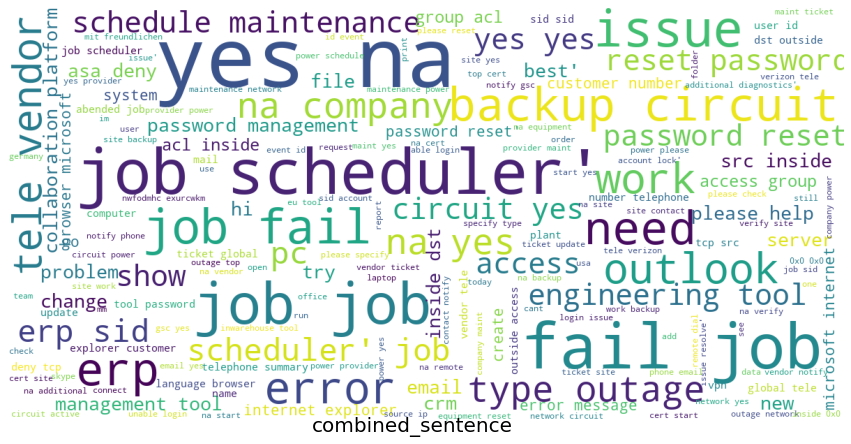

In [29]:
text_Str = clean_df['combined_sentence'].tolist()
show_wordcloud(text_Str,"combined_sentence")

In [30]:
# Lets Get the Max Len
max_len = clean_df['combined_sentence'].apply(lambda x: len(x.split(" "))).max()
max_len

1731

In [31]:
#Convert target variable to integer
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
final_df = clean_df.copy()
final_df['Assignment group']  = labelencoder_X.fit_transform(clean_df['Assignment group']) 
final_df
# generate binary values using get_dummies
# final_df = pd.get_dummies(clean_df, columns=["Assignment group"],prefix=["Grp_"])
# final_df

,combined_sentence,Assignment group
0,verify user detail employee manager name check...,0
1,team meeting skype meeting etc appear outlook ...,0
2,cant hi log vpn best,0
3,unable access hr tool page,0
4,skype error,0
...,...,...
8495,come good afternoon receive email send zz mail...,22
8496,telephony software issue,0
8497,vip window password reset tifpdchb pedxruyf,0
8498,est funcionando unable access machine utility ...,59


**NB with TF-IDF**

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,recall_score

In [50]:
X = final_df[['combined_sentence']]
y = final_df[['Assignment group']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 2) 
X_train

,combined_sentence
35,ticket employment status new non employee
277,dear login skype would pls help check
79,germany mx hard since type outage x network ci...
4166,lopgin able login collaboration platform use e...
334,connect resource access erp hq network drive i...
...,...
1099,company help unable access finance portal hub ...
2514,audio device pc fail play uacyltoe hxgaycze tone
6637,r maus defekt
2575,wireless companysecure outage taiwan please help


In [51]:
#Data preparation – splitting text documents into words
def text_process (x):
    return x.split()
bow_transformer = CountVectorizer(analyzer=text_process).fit(final_df['combined_sentence'])
print(len(bow_transformer.vocabulary_))

15094


In [52]:
print(bow_transformer.get_feature_names()[0])
print(bow_transformer.get_feature_names()[8555])

0
lauthry


In [53]:
#Data preparation – creating indicator features for frequent words
messages_bow = bow_transformer.transform(X_train)
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(1, 15094)


In [56]:
final_df['length'] = final_df['combined_sentence'].apply(lambda x: len(x))
final_df = final_df[final_df['length']>0]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8464 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   combined_sentence  8464 non-null   object
 1   Assignment group   8464 non-null   int64 
 2   length             8464 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 264.5+ KB


In [58]:
x_train = final_df[:6000]['combined_sentence']
y_train = final_df[:6000]['Assignment group']
x_test = final_df[6000:]['combined_sentence']
y_test = final_df[6000:]['Assignment group']

In [59]:
messages_bow = bow_transformer.transform(x_train)
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(6000, 15094)


In [60]:
nb_model = MultinomialNB().fit(messages_tfidf, y_train)

In [62]:
y_pred = nb_model.predict(messages_tfidf)
print(y_pred)

[ 0  0  0 ...  0 72  0]


In [63]:
print(accuracy_score(y, ypred))

0.06270588235294118


Emmbeddings

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

In [65]:
max_features = 10000
embedding_size = 200

In [66]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(final_df['combined_sentence']))

In [67]:
X = tokenizer.texts_to_sequences(final_df['combined_sentence'])
X = pad_sequences(X, maxlen = max_len)
print(len((pd.Series(final_df['Assignment group'])).unique()))
y = np.asarray(final_df['Assignment group'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])


74
Number of Samples: 8464
[  0   0   0 ...  32  10 115]
Number of Labels:  8464
0


In [68]:
#Vocab Size
vocab_size = len(tokenizer.word_index)
print(vocab_size)

15094


In [79]:
from operator import itemgetter
sortedWords = sorted(tokenizer.word_counts.items(), key=itemgetter(1), reverse = True)

In [98]:
most_freq = {}
#print first 15 most frequent words
for i in range(15):
  most_freq[sortedWords[i][0]] = sortedWords[i][1]
  print(sortedWords[i])

('job', 2578)
('yes', 2027)
('please', 2007)
('na', 1943)
('password', 1673)
('user', 1455)
('erp', 1375)
('company', 1277)
('tool', 1232)
('issue', 1175)
('access', 1066)
('ticket', 1059)
('reset', 1042)
('sid', 984)
('scheduler', 971)


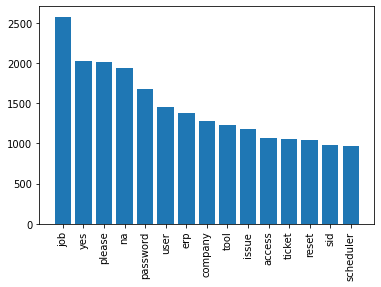

In [99]:
plt.xticks(rotation=90)
plt.bar(range(len(most_freq)), most_freq.values(), align='center')
plt.xticks(range(len(most_freq)), list(most_freq.keys()))
plt.show()

In [69]:
glove_file = "glove.6B.zip"
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [70]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [71]:
num_words = min(max_features, vocab_size)

embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    if i >= num_words: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

LSTM

In [ ]:
embedding_dim = 32
max_length = 200

In [73]:
# model initialization
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(LSTM(300, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(74, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 300)         601200    
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 74)                22274     
Total params: 3,344,674
Trainable params: 3,344,674
Non-trainable params: 0
______________________________________________

In [74]:
batch_size = 100
epochs = 5
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
68/68 [==============================] - 40s 583ms/step - loss: 2.2854 - accuracy: 0.5237 - val_loss: 2.0212 - val_accuracy: 0.5239
Epoch 2/5
68/68 [==============================] - 39s 571ms/step - loss: 1.6890 - accuracy: 0.5913 - val_loss: 1.7886 - val_accuracy: 0.5718
Epoch 3/5
68/68 [==============================] - 39s 570ms/step - loss: 1.4522 - accuracy: 0.6266 - val_loss: 1.6700 - val_accuracy: 0.5836
Epoch 4/5
68/68 [==============================] - 39s 571ms/step - loss: 1.2547 - accuracy: 0.6667 - val_loss: 1.6519 - val_accuracy: 0.5877
Epoch 5/5
68/68 [==============================] - 39s 568ms/step - loss: 1.0671 - accuracy: 0.7077 - val_loss: 1.6654 - val_accuracy: 0.5830


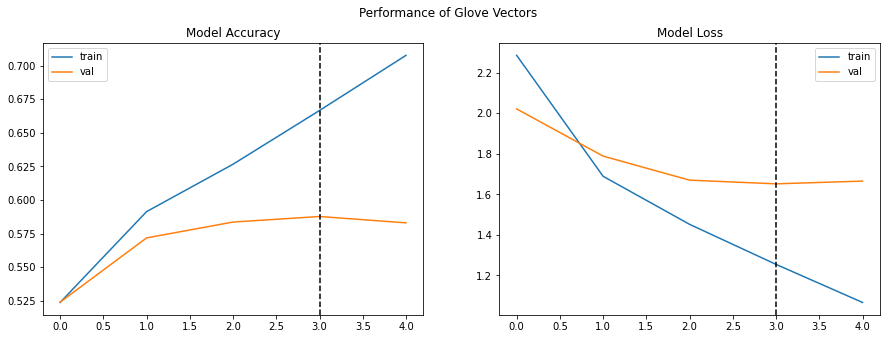

In [76]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'val'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'val'])
plt.show()


BiDirectional LSTM Model

In [75]:
model = Sequential() 
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3)))
model.add(Dense(74, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 74)                19018     
Total params: 2,355,914
Trainable params: 2,355,914
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 100
epochs = 5
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
68/68 [==============================] - 442s 6s/step - loss: 2.4719 - accuracy: 0.5094 - val_loss: 2.1554 - val_accuracy: 0.5147
Epoch 2/5
68/68 [==============================] - 447s 7s/step - loss: 1.7982 - accuracy: 0.5778 - val_loss: 1.8525 - val_accuracy: 0.5612
Epoch 3/5
68/68 [==============================] - 450s 7s/step - loss: 1.5365 - accuracy: 0.6122 - val_loss: 1.7148 - val_accuracy: 0.5765
Epoch 4/5
68/68 [==============================] - 446s 7s/step - loss: 1.3591 - accuracy: 0.6435 - val_loss: 1.6699 - val_accuracy: 0.5859
Epoch 5/5
68/68 [==============================] - 446s 7s/step - loss: 1.2252 - accuracy: 0.6706 - val_loss: 1.5556 - val_accuracy: 0.6094


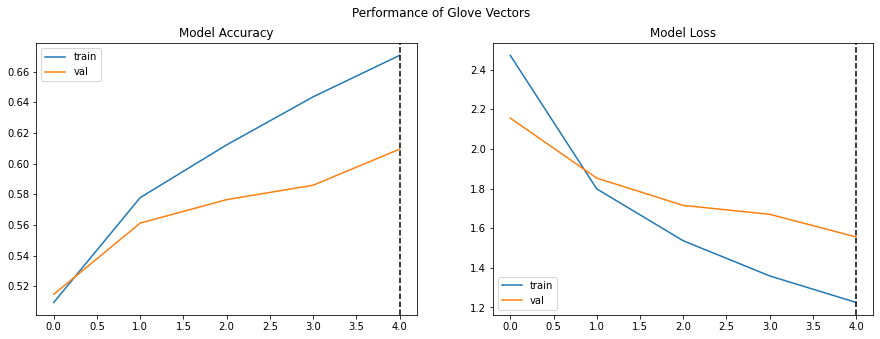

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'val'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'val'])
plt.show()
